# Localization with a known map  - Tutorial: Part 2

Localization with a known map, where the map is given as family of line segments. Moreover we optionally allow the environment to be clutterd with additional boxes, which are not mapped. We refer to such a map as _idealized_.

Todo:
- map in localization model could be model random choice as well and we just fix that so we really have the same model for slam and for localization.

In [1]:
# This is a fix for vscode, because it doesn't like my
# julia docstrings for whatever reason, and throws a `Katex` error.
using Markdown
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [2]:
function sortperm_them!(vals, vecs...)
    perm = sortperm(vals)
    id   = 1:length(vals)
    for v in [vals, vecs...]
        v[id] = v[perm]
    end
end

sortperm_them! (generic function with 1 method)

In [3]:
include("src/localization_part_1.jl")
include("src/localization_part_2.jl")

Loading `../data/data_4.jld2` ...

	_segs      Vector{Segment}
	_boxes     Vector{Segment}
	_center    Vector{Float64}
	_xs        Vector{Vector{Float64}}
	_hds       Vector{Float64}
	_ps        Vector{Pose}
	_dxs       Vector{Vector{Float64}}
	_dhds      Vector{Float64}
	_us        Vector{Control}
	_T         Int64
_segs_   CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}
_boxes_  CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}
_ps_     CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}
_as_     CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}

_fov     Float64
_as      Vector{Float64}
_zs      Vector{Vector{Float64}}
_ys      Vector{Vector{Vector{Float64}}}


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any], true, Union{Nothing, Some{Any}}[nothing, nothing, nothing, Some([:x, :hd])], var"##pose_drift_proposal#457", Bool[0, 0, 0, 0], false)

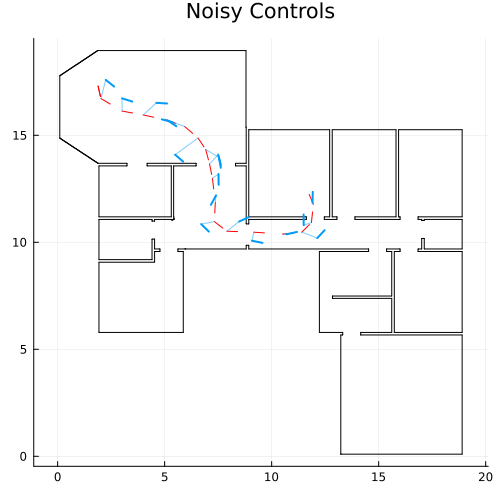

In [84]:
x_noise  = 0.4
hd_noise = 15/360*2π
us_noisy = perturb.(_us, x_noise, hd_noise);

rel_ps = [p+u for (p,u) in zip(_ps[1:end-1],us_noisy)];
ps = [_ps[1]]
for u in us_noisy
    push!(ps, ps[end] + u)
end
# ---------------------
myplot = plot(size=(500,500), 
    title="Noisy Controls",
    aspect_ratio=1., legend=nothing)
plot!(_segs, c=:black)
plot!(_ps[1], c=:red)
plot!(_ps, c=:red)
for (p,q) in zip(_ps[2:end],rel_ps)
    plot!(q, c=col[1], linewidth=2)
    plot!([p.x,q.x], c=col[1], alpha=0.5)
end
savefig("_imgs/loc_us_noisy.png")
display(myplot)

In [18]:
#nbx
"""
Discretize into bins of diameter r, bin-centers lie 
at `z - k*r` for intergers `k`.
"""
quantize(x, r; zero=0) = Int.(floor.((x .+ r./2 .- zero)./r))

quantize

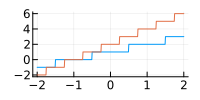

In [20]:
xs  = -2:0.01:2
# ----------------- 
plot(size=(200,100))
plot!(xs, quantize.(xs, 1.0; zero=-1), legend=nothing)
plot!(xs, quantize.(xs, 0.5; zero=-1), legend=nothing)

In [26]:
#nbx
function get_offset(v0, k, r)
    center = (r + k.*r)/2
    return v0 - center
end

function first_grid_vec(v0::Vector{Real}, k::Vector{Int}, r::Vector{Real})
    return r + get_offset(v0, k, r) 
end

"""
    vs, ls = vector_grid(v0, k, r)

Returns grid of vectors and their linear indices, given 
a grid center, numnber of grid points along each dimension and
the resolution along each dimension.
"""
function vector_grid(v0::Vector{Float64}, k::Vector{Int}, r::Vector{Float64})
    # Todo: Does it make sense to get a CUDA version of this?
    offset = get_offset(v0, k, r)
    
    shape = Tuple(k)
    cs = CartesianIndices(shape)
    ls = LinearIndices(shape)
    vs = map(I -> [Tuple(I)...].*r + offset, cs);
    return (vs=vs, linear_indices=ls)
end

# grid_index(x, v0, k, r) = quantize(x, r, zero=get_offset(v0, k, r));
function grid_index(x, v0, k, r; linear=false)
    I = quantize(x, r, zero=get_offset(v0, k, r));
    if linear
        shape = Tuple(k)
        I = LinearIndices(shape)[I...] 
    end
    return I
end

grid_index (generic function with 1 method)

In [6]:
#nbx
"""
    log_ps, ps = eval_pose_vectors(
                    ps_::CuArray,
                    x::Matrix, 
                    ys_::CuArray, as_::CuArray, w::Int, 
                    s_noise::Float64, outlier::Float64, 
                    outlier_vol::Float64=1.0, zmax::Float64=100.0; sorted=false)

Evaluates a collection of poses 
with respect to different Gaussian mixtures...
"""
function eval_pose_vectors(
            vs::Array{Vector{Float64}},
            x::Vector{Vector{Float64}}, 
            segs, as, w::Int, 
            s_noise::Float64, outlier::Float64, outlier_vol::Float64=1.0, 
            zmax::Float64=100.0; sorted=false)
    
    # Compute sensor measurements and 
    # Gaussian mixture components
    # p_  = CuArray(Vector(p))
    # ps_ = reshape(p_, 1, 3)

    ps_ = CuArray(stack(vs[:]))
    x_  = CuArray(stack(x))
    segs_ = CuArray(stack(Vector.(segs)))
    as_ = CuArray(as)

    zs_       = cast_cu(ps_, segs_; fov=_fov, zmax=zmax)
    ys_tilde_ = get_ys_tilde_cu(zs_, as_, w)
        
    # Evaluate the the observations with respect to the 
    # different Gaussian mixtures computed above
    log_ps_, = sensor_logpdf(x_, ys_tilde_, s_noise, outlier, outlier_vol; return_pointwise=false);
    
    # Move everyting back to CPU
    ps     = Vector.(eachrow(Array(ps_)))
    log_ps = Array(log_ps_)

    # Sort by log prob
    # and return 
    if sorted
        perm   = sortperm(log_ps)
        log_ps = log_ps[perm]
        ps     = ps[perm]
    end
    
    return log_ps, ps
end;



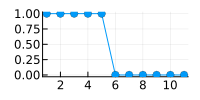

In [7]:
plot(exp.(-750:1:-740) .== 0.0, marker=:o,legend=nothing, size=(200,100))

In [8]:
function exp_normalize(x)
    b = maximum(x)
    y = exp.(x .- b)
    return y / sum(y)
end

exp_normalize (generic function with 1 method)

-2386.716964784724
92.51142870816422
min = 0.0 ,  max = 0.9999999997250775


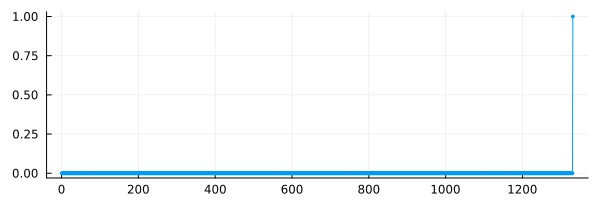

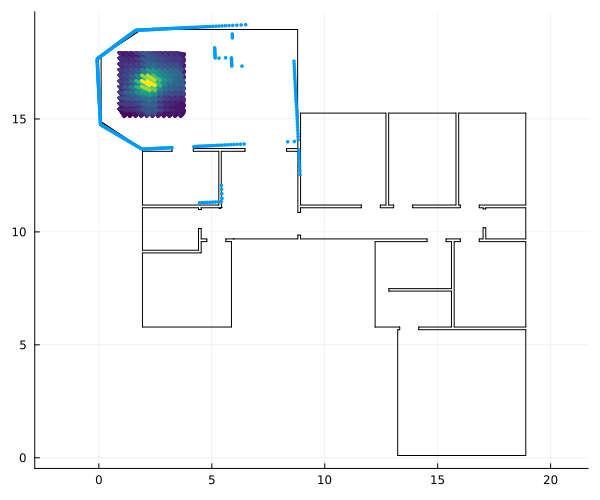

In [9]:
t = 2

ũ  = control_prior_model(0.25, 5/180*π)
p0 = _ps[t] + ũ
v0 = Vector(p0)
k = [11,11,11]
r = [0.25,0.25,5/180*π]
grid_args = (v0, k, r)

vs, = vector_grid(grid_args...)
ps  = stack(vs[:])
x   = _ys[t]


ps_ = CuArray(stack(vs[:]))
x_  = CuArray(stack(x))

as_ = CuArray(_as)

w           = 10
s_noise     = 0.1
outlier     = 1e-1
outlier_vol = 1e2
zmax        = 100.0
sensor_args = (w, s_noise, outlier, outlier_vol, zmax)

log_ps, ps = eval_pose_vectors(vs, x, _segs, _as, sensor_args...; sorted=true);
ps = Pose.(ps)

tau = 1.0
println(minimum(log_ps))
println(maximum(log_ps))

log_ps_tau = log_ps ./ tau
vals = exp_normalize(log_ps_tau)

println("min = $(minimum(vals)) ,  max = $(maximum(vals))")


# -----------------------------
mypl = plot(vals, size=(600,200), marker=:o, markerstrokewidth=0, markersize=2, label=nothing)
display(mypl)
# -----------------------------
mypl = plot(size=(600,500), legend=nothing, aspect_ratio=:equal)
plot!(_segs, c=:black)
cs = cgrad(:viridis)[peak_to_peak(log_ps_tau)]
plot!(ps, cs; r=.4, linewidth=3)
scatter!(x .* ps[end], markerstrokewidth=0, c=col[1], markersize=2)
# plot!(_ps[t],c=:red, linewidth=3)
display(mypl)

In [10]:
@gen function pose_drift_proposal(tr, x_noise, hd_noise, vars=[:x,:hd])
    
    T, = get_args(tr)
    p  = get_pose(tr,T+1)

    if :x in vars 
        x  = {add_addr_prefix(T, :pose => :x)}  ~ diagnormal(p.x, [x_noise, x_noise])
    end

    if :hd in vars 
        hd = {add_addr_prefix(T, :pose => :hd)} ~ normal(p.hd, hd_noise)
    end
    
    tr
end;

In [120]:
#nbx
@gen function grid_proposal(tr::Gen.Trace, 
                            t_chain::Int, 
                            obs_vector,
                            grid_args, 
                            sensor_args, 
                            tau = 1.0,
                            u = Control([0;0],0))

    #
    # Convert from chain-time to model-time
    #
    t = t_chain + 1

    #
    # Create pose vector grid
    # around previous pose p
    #
    p  = get_pose(tr, t)
    v0 = Vector(p + u)
    vs, ls = vector_grid(v0, grid_args...)

    #
    # Evaluate the pose grid with respect 
    # to the observation vector and 
    # devide by the temperature
    # to potentially flatten the probs
    #
    log_ps, ps = eval_pose_vectors(vs, obs_vector, _segs, _as, sensor_args...; sorted=false);    
    log_ps_tau = log_ps ./ tau

    #
    # Sample the new pose p′. 
    # Note that we don't assign the new 
    # pose to a particular time-step. This is done
    # in each of the transforms defined below.
    #
    # Todo: Make the size of the uniform sampling area an argument.
    #
    probs = exp_normalize(log_ps_tau)
    j ~ categorical(probs)
    x′  = {:x}  ~ mvuniform(vs[j][1:2] -  grid_args.r[1:2]/2, vs[j][1:2] + grid_args.r[1:2]/2)
    hd′ = {:hd} ~   uniform(vs[j][3]   -  grid_args.r[3]  /2, vs[j][3]   + grid_args.r[3]  /2)
    
    return Pose(x′, hd′), (j, vs, ls, log_ps)
end

#
# Involution to use the proposal in a MH move
#
@transform involution (tr, aux) to (tr′, aux′) begin
    # Here `aux` is the proposal-trace 
    # and `tr` the slam-trace
    _,t_chain,_,grid_args, = get_args(aux)

    x′  = @read(aux[:x] , :continuous)
    hd′ = @read(aux[:hd], :continuous)
    @write(tr′[add_addr_prefix(t_chain, :pose => :x )],  x′, :continuous)
    @write(tr′[add_addr_prefix(t_chain, :pose => :hd)], hd′, :continuous)
    
end

#
# Involution to use the proposal in a MH move
#
@transform involution2 (tr, aux) to (tr′, aux′) begin
    # Here `aux` is the proposal-trace 
    # and `tr` the slam-trace
    _,t_chain,_,grid_args, = get_args(aux)

    x′  = @read(aux[:x] , :continuous)
    hd′ = @read(aux[:hd], :continuous)
    @write(tr′[add_addr_prefix(t_chain, :pose => :x )],  x′, :continuous)
    @write(tr′[add_addr_prefix(t_chain, :pose => :hd)], hd′, :continuous)
    
    x  = @read(tr[add_addr_prefix(t_chain, :pose => :x )], :continuous)
    hd = @read(tr[add_addr_prefix(t_chain, :pose => :hd)], :continuous)
    j = grid_index([x;hd], [x′;hd′], grid_args..., linear=true)
    @write(aux′[:j],   j, :discrete)
    @write(aux′[:x],   x, :continuous)
    @write(aux′[:hd], hd, :continuous)
end

#
# Transform to use the proposal in a PF update, i.e.
# read in pose at time t and propose pose at time t+1 
#
@transform transform (tr_grid) to (tr_slam) begin
    _,t_chain,_,grid_args, = get_args(tr_grid)
    
    x  = @read(tr_grid[:x], :continuous)
    hd = @read(tr_grid[:hd], :continuous)
    @write(tr_slam[add_addr_prefix(t_chain+1,:pose => :x)],   x, :continuous)
    @write(tr_slam[add_addr_prefix(t_chain+1,:pose => :hd)], hd, :continuous)
end

TraceTransformDSLProgram(var"#326###transform_fn!#1117", nothing)

In [46]:
add_addr_prefix(0,:s)

:s

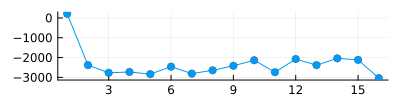

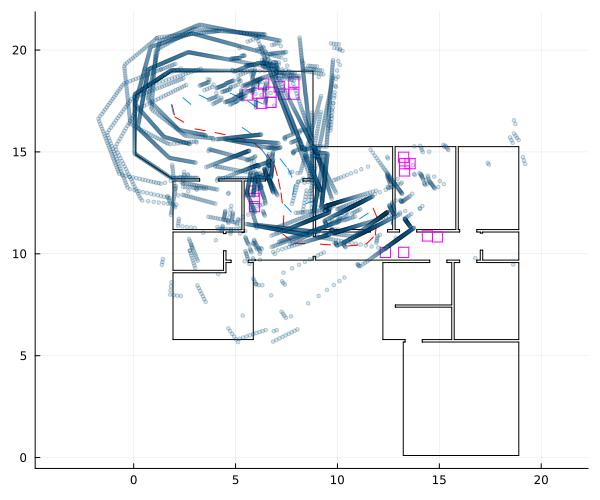

In [134]:
idealized = true
the_map   = idealized ? _segs : vcat(_segs, _boxes);

prior_args = ( 
    p0        = _ps[1],
    x0_noise  = .2,
    hd0_noise = 5/360*2π,
)

motion_args = ( 
    x_noise  = 0.2,
    hd_noise = 5/360*2π
)

sensor_args = (
    w           = 10,
    s_noise     = 0.1,
    outlier     = 1e-2,
    outlier_vol = 1e2,
    zmax        = 100.0,
)

args = (the_map, us_noisy, prior_args..., motion_args..., sensor_args...);

T = 15

ch = choicemap()
for t_chain=0:T
    ch[add_addr_prefix(t_chain, :sensor => :x)] = _ys[t_chain+1]
end

tr, = generate(static_slam_model, (T, args...), ch)

ws = [project.([tr], [select(add_addr_prefix(t, :sensor => :x)) for t=0:T])]

display(plot(ws[1], size=(400,100),legend=nothing, marker=:o))
mypl = plot(size=(600,500), legend=nothing, aspect_ratio=:equal)
plot_slam_trace!(tr)

In [138]:
# add_addr_prefix
x = obs_vector = _ys[1]

grid_args = (
    k = [21,21,21],
    r = [0.1, 0.1, 2/180*π]
)
sensor_args = (
    w           = 20,
    s_noise     = .1,
    outlier     = 1e-2,
    outlier_vol = 1e2,
    zmax        = 100.0,
)
tau = 10.

t_chain = 15
obs_vector = _ys[t_chain+1]
trace_translator  = SymmetricTraceTranslator(grid_proposal, (t_chain, obs_vector, grid_args, sensor_args, tau), involution)
trace_translator2 = SymmetricTraceTranslator(grid_proposal, (t_chain, obs_vector, grid_args, sensor_args, tau), involution2)
(tr′, w′) = trace_translator(tr)
(tr′′, w′′) = trace_translator2(tr)
w′,w′′


(2033.825385152283, 1749.6838028189993)

1
2
3
4
5
6
7
8
10


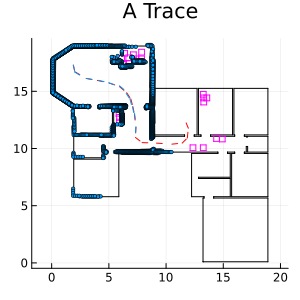

In [64]:
# add_addr_prefix
x = obs_vector = _ys[1]

grid_args = (
    k = [21,21,21],
    r = [0.1, 0.1, 2/180*π]
)
sensor_args = (
    w           = 20,
    s_noise     = .1,
    outlier     = 1e-2,
    outlier_vol = 1e2,
    zmax        = 100.0,
)
tau = 10.




# tr′ = tr
for t_chain=0:T
    obs_vector = _ys[t_chain+1]
    tr′, acc = Gen.mh(tr′, grid_proposal, (t_chain, obs_vector, grid_args, sensor_args, tau), involution)
    if acc
        println(t_chain)
    end
    # display(plot_slam_trace!(tr′))
end
push!(ws, project.([tr′], [select(add_addr_prefix(t,:sensor => :x)) for t=0:T]))

display(plot_slam_trace!(tr′))


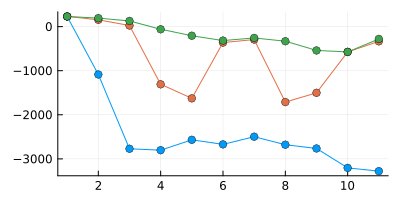

In [65]:
mypl = plot(size=(400,200), legend=nothing)
for w in ws
    plot!(w, marker=:o)
end
display(mypl)


In [45]:
argdiffs(bs::Array{T,1}) where T <: Real = Tuple(map(b -> Bool(b) ? UnknownChange() : NoChange(), bs));
argdiffs([0,0.0,1.0, 1])

(NoChange(), NoChange(), UnknownChange(), UnknownChange())

In [66]:
grid_args = (
    k = [11,11,11],
    r = [0.2, 0.2, 4/180*π]
)
sensor_args = (
    w           = 20,
    s_noise     = .1,
    outlier     = 1e-6,
    outlier_vol = 1e2,
    zmax        = 100.0,
)
tau = 1.

1.0

In [67]:
grid_schedule(grid_args, i) = (k=grid_args.k, r=grid_args.r/2^(i-1)) 

grid_schedule (generic function with 1 method)

In [68]:
using GenParticleFilters
using GenParticleFilters: update_refs!

In [ ]:
# Number of particles 
# and MH updates
N = 10
M = 4
idealized = false

#
# Grid proposal args
#
grid_args = (
    k = [7,7,7],
    r = [0.3, 0.3, 3/180*π]
)
grid_args_fine = (
    k = [21,21,21],
    r = [0.1, 0.1, 1/180*π]
)

#
# Model args
#
the_map   = idealized ? _segs : vcat(_segs, _boxes);

prior_args = ( 
    p0        = _ps[1],
    x0_noise  = .5,
    hd0_noise = 10/360*2π,
)
motion_args = ( 
    x_noise  = 0.2,
    hd_noise = 15/360*2π
)
sensor_args = (
    w           = 20,
    s_noise     = 0.1,
    outlier     = 1e-1,
    outlier_vol = 1e2,
    zmax        = 100.0,
)
model_args = (the_map, us_noisy, prior_args..., motion_args..., sensor_args...);


# Initialize the PF
ch    = constraints(0,_zs,_as);
state = pf_initialize(static_slam_model, (0, model_args...), ch, N);


diffs = argdiffs([1; zeros(length(args))])
times = []
for t=1:_T-1



    #
    # Version 1: Multiple MH updates with the same proposal
    #
    # obs_vector = _ys[t]
    # proposal_args = (t-1, obs_vector,  grid_args_fine, sensor_args, tau);
    # pf_rejuvenate!(state, Gen.mh, (grid_proposal, proposal_args, involution), M);
    
    #
    # Version 2: Multiple MH updates with a scheduled proposal
    #
    obs_vector = _ys[t]
    for (i, tr) in enumerate(state.traces)
        count = 0
        for j = 1:M
            proposal_args = (t-1, obs_vector, grid_schedule(grid_args, j), sensor_args, tau);
            tr, acc = Gen.mh(tr, grid_proposal, proposal_args, involution)
            count += acc
        end
        state.new_traces[i] = tr
    end
    update_refs!(state)

    #
    # Perform residual resampling, pruning low-weight particles
    #
    resample = effective_sample_size(state) < 0.2*N
    if resample   
        method = [:multinomial,:residual][1]
        pf_resample!(state, method)
    end


    ch = constraints(t,_zs,_as);    
    pf_update!(state, (t, model_args...), diffs, ch)

    # obs_vector = _ys[t+1]
    # u = us_noisy[t]
    # proposal_args = (t-1, obs_vector, grid_args_fine, sensor_args, tau, u);
    # pf_update!(state, (t, model_args...), diffs, ch, grid_proposal, proposal_args, transform)


    
#     # # sec = @elapsed dw, = particle_filter_step!(state, (t, args...), diffs, ch)
#     # # r = maybe_resample!(state; ess_threshold=N)
    
    # ms = sec*1_000
    # push!(times, ms)
    # println("$(resample), $(length(Set(state.parents))) ($(nice_f(ms)) ms)")
    println("$(resample), $(length(Set(state.parents)))")
end

In [139]:
# Number of particles 
# and MH updates
N = 10
M = 1
mh_move = [:drift, :fine_grid, :iterated_grid, :none][2]
idealized = true

#
# Grid proposal args
#
grid_args = (
    k = [7,7,7],
    r = [0.3, 0.3, 3/180*π]
)

grid_args_fine = (
    k = [21,21,21],
    r = [0.1, 0.1, 1/180*π]
)

#
# Model args
#
us = us_noisy

prior_args = ( 
    p0        = _ps[1],
    x0_noise  = .5,
    hd0_noise = 10/360*2π,
)
motion_args = ( 
    x_noise  = 0.2,
    hd_noise = 15/360*2π
)
sensor_args = (
    w           = 20,
    s_noise     = 0.1,
    outlier     = 1e-2,
    outlier_vol = 1e2,
    zmax        = 100.0,
)


function pf_experiment(N, M, mh_move, idealized, us, prior_args, motion_args, sensor_args, grid_args, grid_args_fine, tau; verbose=false)

    the_map   = idealized ? _segs : vcat(_segs, _boxes);

    model_args = (the_map, us, prior_args..., motion_args..., sensor_args...);    
    # Initialize the PF
    ch    = constraints(0,_zs,_as);
    state = pf_initialize(static_slam_model, (0, model_args...), ch, N);


    diffs = argdiffs([1; zeros(length(args))])
    times = []
    for t=1:_T
        
        # -- MH method -- 
        # Choose from `[:drift, :fine_grid, :iterated_grid, :none]`
        if mh_move != :none && M > 0

            # Version 1: Multiple MH updates with drift proposal
            if mh_move == :drift
                
                pf_rejuvenate!(state, Gen.mh, (pose_drift_proposal, (0.1, 2/180*π, [:x, :hd])), M)

            # Version 2: Multiple MH updates with fine grid
            elseif mh_move == :fine_grid

                obs_vector = _ys[t]
                proposal_args = (t-1, obs_vector,  grid_args_fine, sensor_args, tau);
                pf_rejuvenate!(state, Gen.mh, (grid_proposal, proposal_args, involution2), M);

            # Version 3: Multiple MH updates with scheduled grid proposals
            elseif mh_move == :iterated_grid

                obs_vector = _ys[t]
                for (i, tr) in enumerate(state.traces)
                    count = 0
                    for j = 1:M
                        proposal_args = (t-1, obs_vector, grid_schedule(grid_args, j), sensor_args, tau);
                        tr, acc = Gen.mh(tr, grid_proposal, proposal_args, involution2)
                        count += acc
                    end
                    state.new_traces[i] = tr
                end
                update_refs!(state)

            end
        end

        #
        # Perform residual resampling (pruning low-weight particles),
        # or "classic" multinomeial resampling
        #
        resample = effective_sample_size(state) < 0.2*N
        if resample   
            method = [:multinomial,:residual][1]
            pf_resample!(state, method)
        end

        if t < _T
            ch = constraints(t,_zs,_as);    
            pf_update!(state, (t, model_args...), diffs, ch)
        end

        #
        # PF update with improved proposal
        #
        # obs_vector = _ys[t+1]
        # u = us_noisy[t]
        # proposal_args = (t-1, obs_vector, grid_args_fine, sensor_args, tau, u);
        # pf_update!(state, (t, model_args...), diffs, ch, grid_proposal, proposal_args, transform)

        if verbose
            println("$(resample), $(length(Set(state.parents)))")
        end
    end
    return state
end

pf_experiment (generic function with 2 methods)

In [140]:
# Number of particles 
# and MH updates
N = 10
M = 1
mh_move = [:drift, :fine_grid, :iterated_grid, :none][2]
idealized = true

#
# Grid proposal args
#
grid_args = (
    k = [9,9,9],
    r = [0.3, 0.3, 3/180*π]
)

grid_args_fine = (
    k = [25,25,25],
    r = [0.1, 0.1, 1/180*π]
)

#
# Model args
#
the_map = idealized ? _segs : vcat(_segs, _boxes);
us      = us_noisy 
prior_args = ( 
    p0        = _ps[1],
    x0_noise  = .5,
    hd0_noise = 10/360*2π,
)
motion_args = ( 
    x_noise  = 0.2,
    hd_noise = 10/360*2π
)
sensor_args = (
    w           = 10,
    s_noise     = 0.1,
    outlier     = 1e-2,
    outlier_vol = 1e2,
    zmax        = 100.0,
)
tau = 10.0


10.0

In [141]:
results = []
configs = [
    # (N=2000, M=0,  mh_move=:none, idealized=true),
    # (N=1000, M=0,  mh_move=:none, idealized=true),
    # (N=100,  M=10, mh_move=:drift, idealized=true),
    (N=10,   M=1,  mh_move=:fine_grid, idealized=true),
    (N=50,   M=4,  mh_move=:iterated_grid, idealized=true),
]

for c in configs
    print(c, " ...")
    exp_args = (c..., us, prior_args, motion_args, sensor_args, grid_args, grid_args_fine, tau)
    sec = @elapsed state = pf_experiment(exp_args...)
    push!(results, (config=c, sec=sec, state=state))
    println("($(sec) secs)")
end

(N = 10, M = 1, mh_move = :fine_grid, idealized = true) ...(26.999478301 secs)
(N = 50, M = 4, mh_move = :iterated_grid, idealized = true) ...(35.296572012 secs)


In [142]:
#nbx
function plot_slam_trace!(tr; show_obs=true)
    T,m, = get_args(tr)
    ps = get_pose.([tr],1:T+1)
    xs = get_obs.([tr],1:T+1)
        
    plot!(_ps, c=:red)
    plot!(ps, c=col[1])
    plot!(_segs,  c=:black)
    myplot = plot!(_boxes, c=:magenta)
    if show_obs
        for (x,p) in zip(xs, ps)
            myplot = scatter!(x .* p, c=col[1], markersize=2, alpha=0.2)
        end
    end
    return myplot
end

plot_slam_trace! (generic function with 1 method)

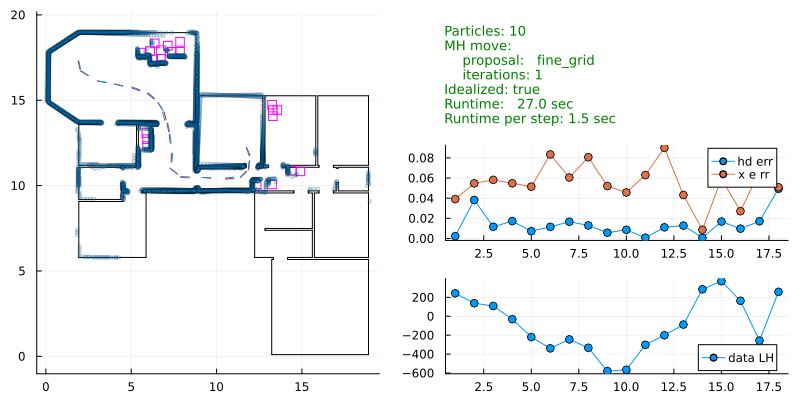

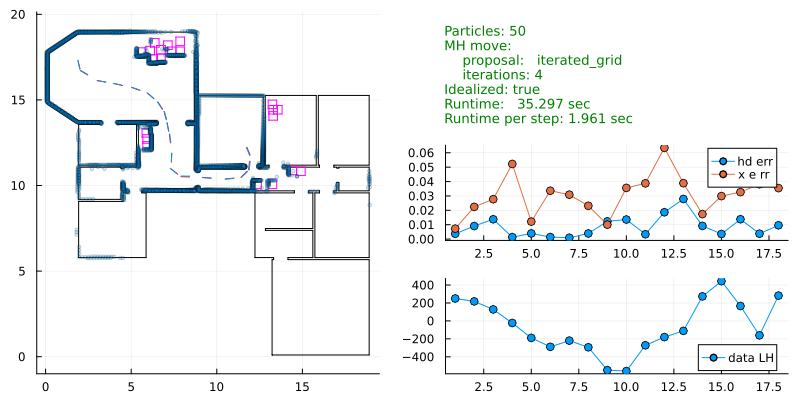

In [143]:
using LinearAlgebra: norm
using LaTeXStrings

for re in results
    
    state = re.state
    c     = re.config

    trs    = state.traces
    ws     = state.log_weights
    scores = get_score.(trs)
    perm   = sortperm(scores)

    trs    = trs[perm]
    ws     = ws[perm]
    scores = scores[perm]


    tr = trs[end]


    qs      = get_pose.([tr],1:_T)
    hd_err  = [abs(p.hd - q.hd) for (p,q) in zip(_ps, qs)]
    x_err   = [norm(p.x - q.x) for (p,q) in zip(_ps, qs)]
    data_lh = project.([tr], [select(add_addr_prefix(t,:sensor => :x)) for t=0:_T-1])
    

    # ---------------------
    ann_plot= plot(xlim=(0,10),ylim=(0,10), showaxis = false, grid=false)
    annotate!(0, 10, text("""
Particles: $(c.N)
MH move: 
    proposal:   $(c.mh_move)  
    iterations: $(c.M)
Idealized: $(c.idealized)
Runtime:   $(ceil(re.sec*1000)/1000) sec
Runtime per step: $(ceil(re.sec/_T*1000)/1000) sec
    """, :left, :top, :green, 9))

    # ---------------------
    lh_plot = plot(size=(600,200))
    plot!(data_lh, label="data LH", marker=:o)

    # ---------------------
    err_plot = plot(size=(600,200))
    plot!(hd_err, label="hd err", marker=:o)
    plot!(x_err, label="x e rr", marker=:o)

    # ---------------------
    tr_plot = plot(
        size=(300,300),  aspect_ratio=1., 
        legend=nothing, 
    )
    plot_slam_trace!(tr; show_obs=true)

    # display("$(re.config)")
    # display(err_plot)

    myplt = plot(tr_plot, ann_plot, err_plot, lh_plot, size=(800,400), 
        titlefont = font(5,"Computer Modern"),
        layout = @layout [
            a [grid(3,1)]
            ])
    display(myplt)
    savefig("_imgs/loc_$(c).png")
    
end

In [100]:
trs    = state.traces
ws     = state.log_weights
scores = get_score.(trs)

perm = sortperm(scores)

trs    = trs[perm]
ws     = ws[perm]
scores = scores[perm]

tr = trs[end]

get_hd(p::Pose) = p.hd/π*180
ps = get_pose.([tr],1:_T)



display(plot(scores, size=(300,100), label="scores"))
display(plot(project.([tr], [select(add_addr_prefix(t,:sensor => :x)) for t=0:_T-1]), size=(300,100),marker=:o ) )
display(plot(get_hd.(_ps) - get_hd.(ps), size=(300,100), label="scores"))
display(plot_slam_trace!(trs[end], show_obs=true))
display(plot_slam_trace!(trs[end], show_obs=false))

LoadError: UndefVarError: state not defined